# CSCI 3202, Spring 2020

# Monday 09 March 2020

# In-class notebook:  Bayesian networks

<a id='top'></a>


<br>

---

Before we begin, let's load a few packages that we might find useful.

In [78]:
from scipy import stats
from math import floor, isclose
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We will start off by creating the Bayesian network from class. See below:

<div>
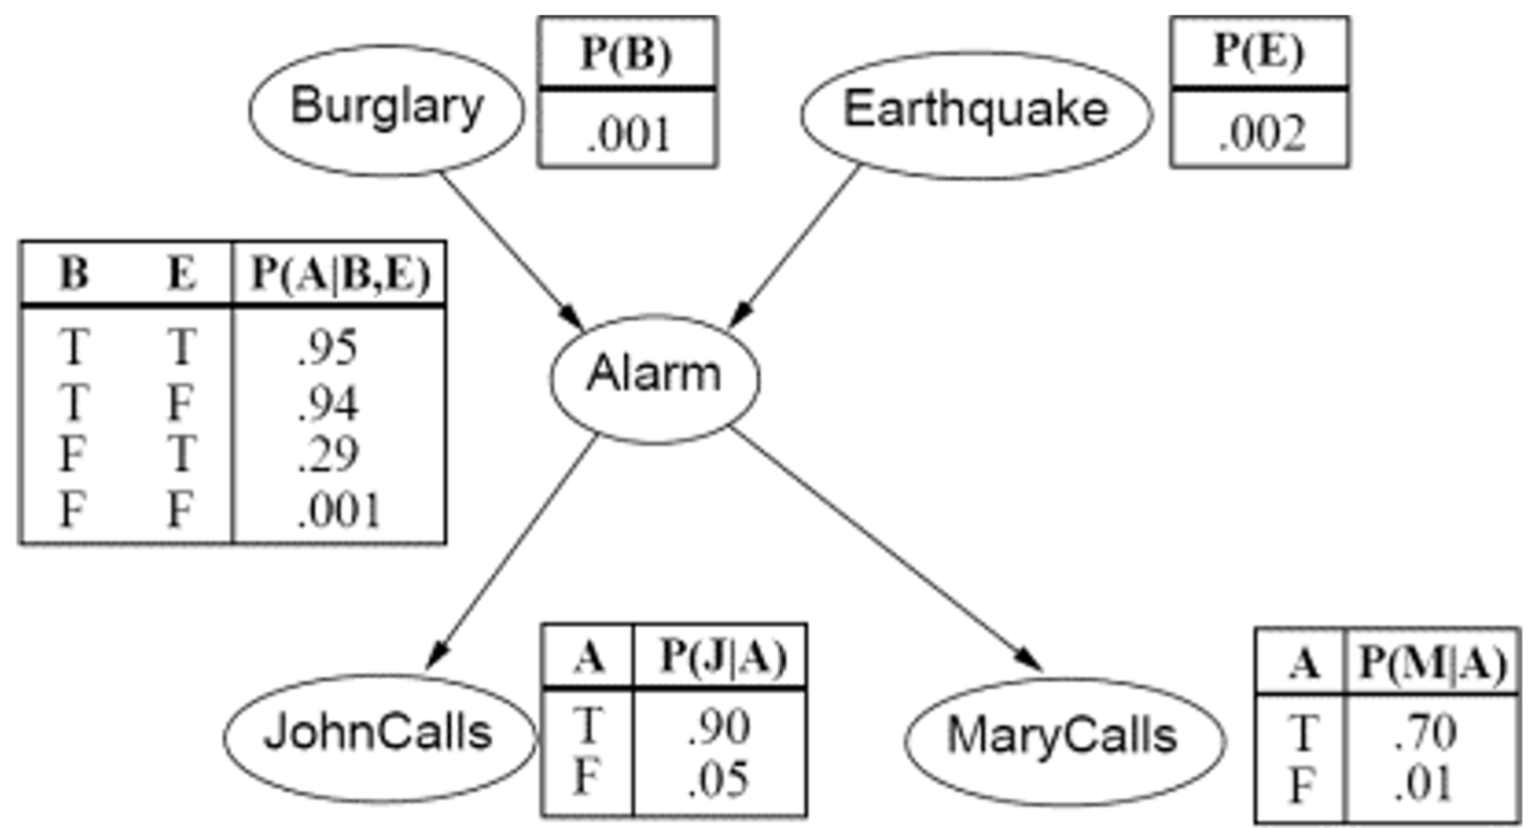
</div>

We will create a `BayesNet` class to model this.  As well as a `BayesNode` class, to represent the variable nodes.  

---
### Class for nodes in a Bayesian network

Below defines a class `BayesNode`, which will store everything we need for a discrete node state in a Bayesian network (Bayes net).

The constructor requires 3 arguments:
* `name` is a string for the variable name
* `parents` is a list of strings representing the names of the parent variables
* `cpt` is a dictionary where the keys are tuples representing parent state values and the dict values are the resulting probabilities of this variable.
  * If this variable has no parents, then the key should be an empty tuple.
  * And recall that it is only necessary to store the probability of `True` for a Boolean variable. In general, we must store the number of possible values minus 1 for any discrete variable state.
  
And if you are curious, that `__repr__` method is defined so that Python returns some reasonable-looking output when we print a `BayesNode` object to screen. (more on this later)

In [2]:
class BayesNode:
    
    def __init__(self, name, parents, values, cpt):
        if isinstance(parents, str):
            parents = parents.split()
            
        if len(parents)==0:
            # if no parents, empty dict key for cpt
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # if there is only one parent, only one tuple argument
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v): p for v, p in cpt.items()}

        self.variable = name
        self.parents = parents
        self.cpt = cpt
        self.values = values
        self.children = []
        
    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))

Since we are only dealing with Boolean variables in this exercise, for brevity's sake we can define `T` and `F` to represent our typical truth values.  But note that here and in other Boolean Bayes net applications, we will frequently use $+x$ to denote the event $X=\text{True}$ and $-x$ for the event $X=\text{False}$.

In [3]:
T, F = True, False

---
### Calculating probabilities from the `BayesNode` objects

Here is a helpful function to calculate the probability of seeing Boolean `BayesNode` variable `var==value`, when the parents' values are given in `evidence`.

In [4]:
def P(var, value, evidence={}):
    '''The probability distribution for P(var | evidence), 
    when all parent variables are known (in evidence)'''
    if len(var.parents)==1:
        # only one parent
        row = evidence[var.parents[0]]
    else:
        # multiple parents
        row = tuple(evidence[parent] for parent in var.parents)

    return var.cpt[row] if value else 1-var.cpt[row]



---
### Class for the Bayesian network

Below defines a class `BayesNet`.

We'll need the following methods:
* `add` Add a new node to the BayesNet, with the given name, parents and conditional probability table (cpt). The parents must already be in the net, and the variable itself must not be.
* `find_node` Find and return the BayesNode with name `var`
* `find_values` Return the set of possible values for variable `var`

In [5]:
class BayesNet:
    '''Bayesian network containing only boolean-variable nodes.'''

    def __init__(self, node_specs=[]):
        '''node_specs is a list of tuples, one per node
        each node has (name, parents, cpt) and nodes must 
        be ordered with parents before children.'''
        self.nodes = []
        self.variables = []
        for node_spec in node_specs:
            self.add(*node_spec)

    def add(self, name, parents, values, cpt):
        '''Add a new node to the BayesNet, with the given name, parents and
        conditional probability table (cpt). The parents must already be in
        the net, and the variable itself must not be.'''
        node = BayesNode(name=name, parents=parents, values=values, cpt=cpt)
        assert node.variable not in self.variables
        assert all((parent in self.variables) for parent in node.parents)
        self.nodes.append(node)
        self.variables.append(node.variable)
        for parent in node.parents:
            self.find_node(parent).children.append(node)

    def find_node(self, var):
        '''Find and return the BayesNode with name `var`'''
        for n in self.nodes:
            if n.variable == var:
                return n
        raise Exception("No such variable: {}".format(var))

    def find_values(self, var):
        '''Return the set of possible values for variable `var`'''
        varnode = self.find_node(var)
        return varnode.values

    def __repr__(self):
        return 'BayesNet({0!r})'.format(self.nodes)

Next, we need to define a class called `PDF_discrete` that defines a discrete probability function.

In [62]:
class PDF_discrete:
    '''Define a discrete probability distribution function.'''

    def __init__(self, varname='?', freqs=None):
        '''Create a dictionary of values - frequency pairs,
        then normalize the distribution to sum to 1.'''
        self.prob = {}
        self.varname = varname
        self.values = []
        if freqs:
            for (v, p) in freqs.items():
                self[v] = p
        self.normalize()

    def __getitem__(self, value):
        '''Given a value, return P[value]'''
        try:
            return self.prob[value]
        except KeyError:
            return 0

    def __setitem__(self, value, p):
        '''Set P[value] = p, input argument if '''
        if value not in self.values:
            self.values.append(value)
        self.prob[value] = p

    def normalize(self):
        '''Normalize the probability distribution and return it.
        If the sum of PDF values is 0, then return a 0'''
        total = sum(self.prob.values())
        if not isclose(total, 1.0):
            for value in self.prob:
                self.prob[value] /= total
        return self
    
def extend(s, var, val):
    """Copy the substitution s and extend it by setting var to val; return copy."""
    s2 = s.copy()
    print("Pre",s2)
    s2[var] = val
    print("Post",s2)
    return s2

Now, we'll want to write two functions: 
- `enumeration_ask` which will return the conditional probability distribution of variable X given evidence e, from BayesNet
- `enumerate_all` which will return the sum of those entries in P(variables | e{others}) consistent with e, where P is the joint distribution represented by bn, and e{others} means e restricted to bn's other variables (the ones other than variables). Parents must precede children in variables.

In [74]:
def enumeration_ask(X, e, bn):
    '''Return the conditional probability distribution of variable X
    given evidence e, from BayesNet bn. [Figure 14.9]'''
    Q = PDF_discrete(X)
    print("X",X)
    print("e",e)
    for xi in bn.find_values(X):
        Q[xi] = enumerate_all(bn.variables, extend(e, X, xi), bn)
        print(Q.prob)
        #print(Q.normalize())
    return Q.normalize()


def enumerate_all(variables, e, bn):
    '''Return the sum of those entries in P(variables | e{others})
    consistent with e, where P is the joint distribution represented
    by bn, and e{others} means e restricted to bn's other variables
    (the ones other than variables). Parents must precede children in variables.'''
    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    print("Y",Y)
    print("rest", rest)
    Ynode = bn.find_node(Y)
    
    if Y in e:
        # Y in evidence, so we know its value and just multiply
        print("Case where Y is in evidence",P(Ynode, e[Y], e) * enumerate_all(rest, e, bn))
        return P(Ynode, e[Y], e) * enumerate_all(rest, e, bn)
    else:
        # Y not in evidence so we have to sum (Law of Total Prob.)    
        return sum(P(Ynode, y, e) * enumerate_all(rest, extend(e, Y, y), bn)
                   for y in bn.find_values(Y))

Alright, let's create a Bayes' net.

In [75]:
burglary = BayesNet([
    ('Burglary', '', [T,F], 0.001),
    ('Earthquake', '', [T,F], 0.002),
    ('Alarm', ['Burglary', 'Earthquake'], [T,F], {(T, T): 0.95, (T, F): 0.94, (F, T): 0.29, (F, F): 0.001}),
    ('JohnCalls', 'Alarm', [T,F], {T: 0.90, F: 0.05}),
    ('MaryCalls', 'Alarm', [T,F], {T: 0.70, F: 0.01})
])

In [76]:
p1 = enumeration_ask(X='Burglary', e={'JohnCalls' : T, 'MaryCalls' : T}, bn=burglary)

X Burglary
e {'JohnCalls': True, 'MaryCalls': True}
Pre {'JohnCalls': True, 'MaryCalls': True}
Post {'JohnCalls': True, 'MaryCalls': True, 'Burglary': True}
Y Burglary
rest ['Earthquake', 'Alarm', 'JohnCalls', 'MaryCalls']
Y Earthquake
rest ['Alarm', 'JohnCalls', 'MaryCalls']
Pre {'JohnCalls': True, 'MaryCalls': True, 'Burglary': True}
Post {'JohnCalls': True, 'MaryCalls': True, 'Burglary': True, 'Earthquake': True}
Y Alarm
rest ['JohnCalls', 'MaryCalls']
Pre {'JohnCalls': True, 'MaryCalls': True, 'Burglary': True, 'Earthquake': True}
Post {'JohnCalls': True, 'MaryCalls': True, 'Burglary': True, 'Earthquake': True, 'Alarm': True}
Y JohnCalls
rest ['MaryCalls']
Y MaryCalls
rest []
Case where Y is in evidence 0.7
Case where Y is in evidence 0.63
Y MaryCalls
rest []
Case where Y is in evidence 0.7
Pre {'JohnCalls': True, 'MaryCalls': True, 'Burglary': True, 'Earthquake': True}
Post {'JohnCalls': True, 'MaryCalls': True, 'Burglary': True, 'Earthquake': True, 'Alarm': False}
Y JohnCalls
res

In [77]:
p1.prob

{True: 0.2841718353643929, False: 0.7158281646356071}